# Conv-VAE: MNIST + PyTorch

[Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)

In [ ]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
# import plotly
# import plotly.express as px
import seaborn as sns
import numpy as np

In [2]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")
    
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 2.0.0
Number of GPU(s) available = 0
PyTorch does not have access to GPU
Available device is cpu


In [3]:
# Specify hyper-parameters-
num_epochs = 100
batch_size = 512
learning_rate = 0.001

### MNIST data pre-processing

In [4]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [5]:
path_to_data = "/home/amajumdar/Downloads/.data/"

In [6]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
    # root = './data', train = True,
    root = path_to_data, train = True,
    transform = transforms_apply, download = True
)

test_dataset = torchvision.datasets.MNIST(
    # root = './data', train = False,
    root = path_to_data, train = False,
    transform = transforms_apply
)

In [7]:
len(train_dataset.targets), len(train_dataset.data)

(60000, 60000)

In [8]:
len(test_dataset.targets), len(test_dataset.data)

(10000, 10000)

In [9]:
print(f"training dataset length/shape: {list(train_dataset.data.size())}")

training dataset length/shape: [60000, 28, 28]


In [10]:
print(f"mean = {train_dataset.data.float().mean() / 255:.4f}")
print(f"std dev = {train_dataset.data.float().std() / 255:.4f}")

mean = 0.1307
std dev = 0.3081


Note: Since MNIST has only one channel, therefore, the mean and standard deviation is computed for one channel!

In [11]:
# Sanity check-
train_dataset.data.min(), train_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [12]:
test_dataset.data.min(), test_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [13]:
# Scale pixel values in the range 0 to 1
# To manually convert the pixel values in the range 0 to 1, divide the training and testing
# datasets by 255.0-
train = train_dataset.data.float() / 255.0
test = test_dataset.data.float() / 255.0

In [14]:
# Reshape to include gray-scale channel-
train = train.reshape(60000, 1, 28, 28)
test = test.reshape(10000, 1, 28, 28)

In [15]:
train.shape, test.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [16]:
# Sanity check- min and max pixel values are in the range 0 to 1-
train.data.min(), train.data.max()

(tensor(0.), tensor(1.))

In [17]:
test.data.min(), test.data.max()

(tensor(0.), tensor(1.))

In [18]:
del train_dataset, test_dataset

In [19]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test, batch_size = batch_size,
    shuffle = False
)

In [20]:
print(f"Sizes of train_dataset: {len(train)} and test_dataet: {len(test)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 118 and test_loader: 20


In [21]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 118 & len(test_loader) = 20


In [22]:
# Sanity check-
len(train) / batch_size, len(test) / batch_size

(117.1875, 19.53125)

In [25]:
# Get some random batch of training images & labels-
images = next(iter(train_loader))

# You get 64 images due to the specified batch size-
# print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")
print(f"images.shape: {images.shape}")

images.shape: torch.Size([512, 1, 28, 28])


In [26]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [27]:
# De-normalize the batch of images-
images *= 255.0

images.min(), images.max()

(tensor(0.), tensor(255.))

In [28]:
# Reshape images for visualization-
images = images.view(-1, 1, 28, 28)

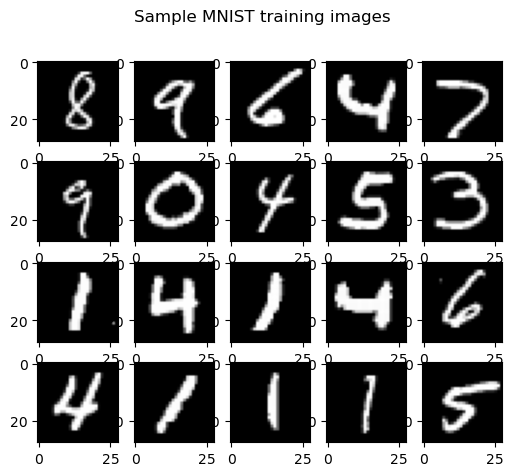

In [29]:
# Visualize 20 images from training set-
plt.figure(figsize = (6, 5))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

In [30]:
del images

### Conv-VAE architecture

In [23]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, capacity):
        super().__init__()
        
        self.capacity = capacity
        self.latent_dim = latent_dim
        
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = self.capacity,
            kernel_size = 4, stride = 2,
            padding = 1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(
            in_channels = self.capacity, out_channels = self.capacity * 2,
            kernel_size = 4, stride = 2,
            padding = 1) # out: c x 7 x 7
        self.dense = nn.Linear(in_features = self.capacity * 2 * 7 * 7, out_features = 100)
        self.dense2 = nn.Linear(in_features = 100, out_features = self.latent_dim)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = F.relu(self.dense(x))
        x = F.relu(self.dense2(x))
        return x

    
class Decoder(nn.Module):
    def __init__(self, latent_dim, capacity):
        super().__init__()
        
        self.capacity = capacity
        self.latent_dim = latent_dim
        
        self.dense = nn.Linear(in_features = self.latent_dim, out_features = 100) 
        self.dense2 = nn.Linear(in_features = 100, out_features = self.capacity * 2 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(
            in_channels = self.capacity * 2, out_channels = self.capacity,
            kernel_size = 4, stride = 2,
            padding = 1
        )
        self.conv2 = nn.ConvTranspose2d(
            in_channels = self.capacity, out_channels = 1,
            kernel_size = 4, stride = 2, 
            padding = 1
        )
        
        
    def forward(self, x):
        x = self.dense(x)
        x = self.dense2(x)
        x = x.view(x.size(0), self.capacity * 2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    

In [24]:
class CVAE(nn.Module):
    def __init__(self, latent_dim, capacity):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.capacity = capacity
        
        self.encoder = Encoder(latent_dim = self.latent_dim, capacity = self.capacity)
        self.decoder = Decoder(latent_dim = self.latent_dim, capacity = self.capacity)
        
        self.mu = nn.Linear(in_features = self.latent_dim, out_features = self.latent_dim)
        self.log_var = nn.Linear(in_features = self.latent_dim, out_features = self.latent_dim)
        
        self.initialize_weights()
    
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        
        The log-var trick allows us to have both positive and negative values instead
        of only having positive values if standard deviation was used. Having both
        positive & negative values is good for the neural network training process.
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' is sampled from a standard normal distribution
        # to add stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        z = mu + (std * eps)
        
        return z
    
        
    def forward(self, x):
        x_enc = self.encoder(x)
        mu = self.mu(x_enc)
        logvar = self.log_var(x_enc)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, logvar)
        
        x_recon = self.decoder(z)
        return x_recon, mu, logvar
        
        

In [26]:
# Instantiate a Conv-VAE model-
model = CVAE(latent_dim = 5, capacity = 16).to(device)

In [27]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

In [28]:
print(f"Total number of parameters in Conv VAE model = {tot_params}")

Total number of parameters in Conv VAE model = 333394


In [29]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [ ]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(
    params = model.parameters(), lr = learning_rate,
    weight_decay = 5e-4
)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [26]:
def compute_loss(x, x_recon, mu, logvar, alpha = 1):
    '''
    Function to compute loss = reconstruction loss * reconstruction_term_weight + KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. mu: mean from the latent vector
    2. logvar: log variance from the latent vector
    3. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss - reconstruction term weight
    4. x: training data
    5. x_recon: VAE's reconstructed data
    '''
    
    # Compute KL-Divergence loss:
    
    # Sum over latent dimensions-
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar), axis = 1)
    
    '''
    Omitting 'axis' will give bad results as it will sum over everything!
    First, sum over the latent dimensions and then average over the batches.
    '''
    
    # kl_div.shape
    # torch.Size([64])
    
    batchsize = kl_div.size(0)

    # Compute average KL-divergence over batch size-
    kl_div = kl_div.mean()
    
    
    # Compute Reconstruction loss:
    
    reconstruction_loss_fn = F.mse_loss
    recon_loss = reconstruction_loss_fn(x_recon, x, reduction = 'none')
    
    # recon_loss.shape
    # torch.Size([32, 1, 28, 28])
    
    # Sum over all pixels-
    # Reshape recon_loss so that it is the batchsize and a vector. So, instead
    # of having a tensor, it is now a matrix (table). Then, sum over the pixels.
    # This is equivalent to summing over the latent dimensions for kl_div above.
    # We are summing first the squared error over the pixels and then average over
    # the batch dimensions below-
    recon_loss = recon_loss.view(batchsize, -1).sum(axis = 1)
    
    # recon_loss.shape
    # torch.Size([64, 784])
    
    # Average over mini-batch dimension-
    recon_loss = recon_loss.mean()
    
    final_loss = (alpha * recon_loss) + kl_div
    
    return final_loss, recon_loss, kl_div


In [ ]:
'''
def compute_loss(x, x_recon, mu, logvar):
    recon_loss = F.binary_cross_entropy(x_recon.view(-1, 784), x.view(-1, 784), reduction = 'sum')

    # recon_loss.size()
    # torch.Size([])

    # recon_loss = F.binary_cross_entropy(x_recon.view(-1, 784), x.view(-1, 784), reduction = 'none')

    # recon_loss.size()
    # torch.Size([512, 784])

    # recon_loss = F.mse_loss(x_recon.view(-1, 784), x.view(-1, 784), reduction = 'sum')
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div, recon_loss, kl_div
'''

In [27]:
def train_one_epoch(model, dataloader, train_dataset):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to keep track of 3 losses-
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    
    for i, data in tqdm(
        enumerate(dataloader),
        total = int(len(train_dataset) / dataloader.batch_size)
        # total = int(len(train) / dataloader.batch_size)
        ):
      
        # Ignore labels-
        # data, _ = data

        # Push data points to 'device'-
        data = data.to(device)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        recon_data, mu, logvar = model(data)
        
        final_loss, recon_loss, kl_div_loss = compute_loss(
            x = data, x_recon = recon_data,
            mu = mu, logvar = logvar,
        )
        
        # Update losses-
        running_final_loss += final_loss.item()
        running_kl_loss += kl_div_loss.cpu().detach().numpy()
        running_recon_loss += recon_loss.cpu().detach().numpy()
        
        # Compute gradients wrt total loss-
        final_loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
    
    # Compute losses as float values-
    train_loss = running_final_loss / len(dataloader.dataset)
    kl_loss = running_kl_loss / len(dataloader.dataset)
    recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return train_loss, kl_loss, recon_loss


def validate_one_epoch(model, dataloader, test_dataset):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            total = int(len(test_dataset) / dataloader.batch_size)):
            # total = int(len(test) / test_loader.batch_size)):
          
            # Ignore labels-
            # data, _ = data

            # Push data points to 'device'-
            data = data.to(device)
            
            # Perform forward propagation-
            recon_data, mu, logvar = model(data)
            
            final_loss, recon_loss, kl_div_loss = compute_loss(
                x = data, x_recon = recon_data,
                mu = mu, logvar = logvar,
            )
        
            # Update losses-
            running_final_loss += final_loss.item()
            running_kl_loss += kl_div_loss.cpu().detach().numpy()
            running_recon_loss += recon_loss.cpu().detach().numpy()
            
                
    val_loss = running_final_loss / len(dataloader.dataset)
    val_kl_loss = running_kl_loss / len(dataloader.dataset)
    val_recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return val_loss, val_kl_loss, val_recon_loss


In [ ]:
'''
train_loss, kl_loss, recon_loss = train_one_epoch(
    model = model, dataloader = train_loader,
    train_dataset = train
)

val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
    model = model, dataloader = test_loader,
    test_dataset = test
)
'''

In [33]:
# Python dict to contain training metrics-
train_history = {}

In [34]:
print(f"Training Conv-VAE model for {num_epochs} epochs")

Training Conv-VAE model for 100 epochs


In [35]:
# To save 'best' parameters-
best_test_loss = 10000

In [36]:
for epoch in range(1, num_epochs + 1):
    
    train_loss, kl_loss, recon_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        train_dataset = train
    )
    test_loss, test_kl_loss, test_recon_loss = validate_one_epoch(
        model = model, dataloader = test_loader,
        test_dataset = test
    )
    
    train_history[epoch] = {
        'train_loss': train_loss,
        'train_kl_loss': kl_loss,
        'train_recon_loss': recon_loss,
        'test_loss': test_loss,
        'test_kl_loss': test_kl_loss,
        'test_recon_loss': test_recon_loss
    }
    
    print(f"epoch: {epoch}, loss = {train_loss:.6f},"
          f" recon loss = {kl_loss:.6f}, kl-loss = {kl_loss:.6f},"
          f" test loss = {test_loss:.6f}, kl-loss = {test_kl_loss:.6f}"
          f" & recon loss = {test_recon_loss:.6f}"
         )
    
    # Save 'best' parameters-
    if (test_loss < best_test_loss):

        best_test_loss = test_loss
        print(f"Saving model with lowest test_loss = {test_loss:.6f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ConvVAE_MNIST_best_model.pth")
        

118it [00:05, 21.63it/s]                                                                                                                                    
20it [00:00, 36.77it/s]                                                                                                                                     


epoch: 1, loss = 0.142799, recon loss = 0.009846, kl-loss = 0.009846, test loss = 0.113735, kl-loss = 0.007156 & recon loss = 0.106579
Saving model with lowest test_loss = 0.113735



118it [00:05, 19.80it/s]                                                                                                                                    
20it [00:00, 33.63it/s]                                                                                                                                     


epoch: 2, loss = 0.110223, recon loss = 0.006211, kl-loss = 0.006211, test loss = 0.111004, kl-loss = 0.005831 & recon loss = 0.105173
Saving model with lowest test_loss = 0.111004



118it [00:05, 20.50it/s]                                                                                                                                    
20it [00:00, 42.61it/s]                                                                                                                                     


epoch: 3, loss = 0.107957, recon loss = 0.005202, kl-loss = 0.005202, test loss = 0.108754, kl-loss = 0.004763 & recon loss = 0.103991
Saving model with lowest test_loss = 0.108754



118it [00:05, 23.31it/s]                                                                                                                                    
20it [00:00, 42.90it/s]                                                                                                                                     


epoch: 4, loss = 0.105638, recon loss = 0.004746, kl-loss = 0.004746, test loss = 0.106354, kl-loss = 0.004526 & recon loss = 0.101828
Saving model with lowest test_loss = 0.106354



118it [00:05, 22.30it/s]                                                                                                                                    
20it [00:00, 43.05it/s]                                                                                                                                     


epoch: 5, loss = 0.103059, recon loss = 0.004277, kl-loss = 0.004277, test loss = 0.103563, kl-loss = 0.003932 & recon loss = 0.099631
Saving model with lowest test_loss = 0.103563



118it [00:05, 21.35it/s]                                                                                                                                    
20it [00:00, 44.53it/s]                                                                                                                                     


epoch: 6, loss = 0.100529, recon loss = 0.003676, kl-loss = 0.003676, test loss = 0.101275, kl-loss = 0.003665 & recon loss = 0.097610
Saving model with lowest test_loss = 0.101275



118it [00:05, 20.97it/s]                                                                                                                                    
20it [00:00, 44.38it/s]                                                                                                                                     


epoch: 7, loss = 0.099061, recon loss = 0.003559, kl-loss = 0.003559, test loss = 0.100085, kl-loss = 0.003526 & recon loss = 0.096559
Saving model with lowest test_loss = 0.100085



118it [00:05, 19.76it/s]                                                                                                                                    
20it [00:00, 47.16it/s]                                                                                                                                     


epoch: 8, loss = 0.098163, recon loss = 0.003572, kl-loss = 0.003572, test loss = 0.099203, kl-loss = 0.003603 & recon loss = 0.095600
Saving model with lowest test_loss = 0.099203



118it [00:05, 21.20it/s]                                                                                                                                    
20it [00:00, 44.73it/s]                                                                                                                                     


epoch: 9, loss = 0.097351, recon loss = 0.003646, kl-loss = 0.003646, test loss = 0.098516, kl-loss = 0.003509 & recon loss = 0.095007
Saving model with lowest test_loss = 0.098516



118it [00:05, 22.69it/s]                                                                                                                                    
20it [00:00, 42.24it/s]                                                                                                                                     


epoch: 10, loss = 0.096671, recon loss = 0.003668, kl-loss = 0.003668, test loss = 0.097852, kl-loss = 0.003868 & recon loss = 0.093984
Saving model with lowest test_loss = 0.097852



118it [00:05, 21.65it/s]                                                                                                                                    
20it [00:00, 37.05it/s]                                                                                                                                     


epoch: 11, loss = 0.095968, recon loss = 0.003747, kl-loss = 0.003747, test loss = 0.097257, kl-loss = 0.003868 & recon loss = 0.093389
Saving model with lowest test_loss = 0.097257



118it [00:05, 20.39it/s]                                                                                                                                    
20it [00:00, 38.25it/s]                                                                                                                                     


epoch: 12, loss = 0.095385, recon loss = 0.003866, kl-loss = 0.003866, test loss = 0.096485, kl-loss = 0.003955 & recon loss = 0.092530
Saving model with lowest test_loss = 0.096485



118it [00:05, 20.49it/s]                                                                                                                                    
20it [00:00, 39.52it/s]                                                                                                                                     


epoch: 13, loss = 0.094752, recon loss = 0.003918, kl-loss = 0.003918, test loss = 0.096158, kl-loss = 0.004138 & recon loss = 0.092020
Saving model with lowest test_loss = 0.096158



118it [00:06, 18.85it/s]                                                                                                                                    
20it [00:00, 37.48it/s]                                                                                                                                     


epoch: 14, loss = 0.094091, recon loss = 0.004017, kl-loss = 0.004017, test loss = 0.095548, kl-loss = 0.004225 & recon loss = 0.091323
Saving model with lowest test_loss = 0.095548



118it [00:05, 21.89it/s]                                                                                                                                    
20it [00:00, 45.05it/s]                                                                                                                                     


epoch: 15, loss = 0.093588, recon loss = 0.004113, kl-loss = 0.004113, test loss = 0.094554, kl-loss = 0.004205 & recon loss = 0.090349
Saving model with lowest test_loss = 0.094554



118it [00:05, 19.96it/s]                                                                                                                                    
20it [00:00, 37.33it/s]                                                                                                                                     


epoch: 16, loss = 0.093008, recon loss = 0.004259, kl-loss = 0.004259, test loss = 0.094057, kl-loss = 0.004359 & recon loss = 0.089698
Saving model with lowest test_loss = 0.094057



118it [00:06, 18.81it/s]                                                                                                                                    
20it [00:00, 36.08it/s]                                                                                                                                     


epoch: 17, loss = 0.092393, recon loss = 0.004376, kl-loss = 0.004376, test loss = 0.094089, kl-loss = 0.004671 & recon loss = 0.089419


118it [00:05, 21.99it/s]                                                                                                                                    
20it [00:00, 41.65it/s]                                                                                                                                     


epoch: 18, loss = 0.091212, recon loss = 0.004684, kl-loss = 0.004684, test loss = 0.091813, kl-loss = 0.004804 & recon loss = 0.087008
Saving model with lowest test_loss = 0.091813



118it [00:06, 18.91it/s]                                                                                                                                    
20it [00:00, 31.59it/s]                                                                                                                                     


epoch: 19, loss = 0.090033, recon loss = 0.004812, kl-loss = 0.004812, test loss = 0.090783, kl-loss = 0.004868 & recon loss = 0.085915
Saving model with lowest test_loss = 0.090783



118it [00:05, 20.05it/s]                                                                                                                                    
20it [00:00, 30.78it/s]                                                                                                                                     


epoch: 20, loss = 0.089096, recon loss = 0.004907, kl-loss = 0.004907, test loss = 0.090106, kl-loss = 0.005097 & recon loss = 0.085009
Saving model with lowest test_loss = 0.090106



118it [00:05, 20.48it/s]                                                                                                                                    
20it [00:00, 38.36it/s]                                                                                                                                     


epoch: 21, loss = 0.088446, recon loss = 0.004993, kl-loss = 0.004993, test loss = 0.089665, kl-loss = 0.005052 & recon loss = 0.084614
Saving model with lowest test_loss = 0.089665



118it [00:06, 18.86it/s]                                                                                                                                    
20it [00:00, 39.12it/s]                                                                                                                                     


epoch: 22, loss = 0.087844, recon loss = 0.005073, kl-loss = 0.005073, test loss = 0.088837, kl-loss = 0.005058 & recon loss = 0.083779
Saving model with lowest test_loss = 0.088837



118it [00:06, 17.74it/s]                                                                                                                                    
20it [00:00, 35.43it/s]                                                                                                                                     


epoch: 23, loss = 0.087333, recon loss = 0.005148, kl-loss = 0.005148, test loss = 0.088322, kl-loss = 0.005140 & recon loss = 0.083183
Saving model with lowest test_loss = 0.088322



118it [00:06, 18.83it/s]                                                                                                                                    
20it [00:00, 34.18it/s]                                                                                                                                     


epoch: 24, loss = 0.086957, recon loss = 0.005210, kl-loss = 0.005210, test loss = 0.088032, kl-loss = 0.005338 & recon loss = 0.082695
Saving model with lowest test_loss = 0.088032



118it [00:05, 19.69it/s]                                                                                                                                    
20it [00:00, 38.58it/s]                                                                                                                                     


epoch: 25, loss = 0.086620, recon loss = 0.005330, kl-loss = 0.005330, test loss = 0.087894, kl-loss = 0.005414 & recon loss = 0.082481
Saving model with lowest test_loss = 0.087894



118it [00:05, 20.15it/s]                                                                                                                                    
20it [00:00, 34.31it/s]                                                                                                                                     


epoch: 26, loss = 0.085023, recon loss = 0.006250, kl-loss = 0.006250, test loss = 0.084282, kl-loss = 0.007634 & recon loss = 0.076648
Saving model with lowest test_loss = 0.084282



118it [00:05, 21.67it/s]                                                                                                                                    
20it [00:00, 40.25it/s]                                                                                                                                     


epoch: 27, loss = 0.081995, recon loss = 0.007631, kl-loss = 0.007631, test loss = 0.082577, kl-loss = 0.007824 & recon loss = 0.074752
Saving model with lowest test_loss = 0.082577



118it [00:05, 20.25it/s]                                                                                                                                    
20it [00:00, 36.58it/s]                                                                                                                                     


epoch: 28, loss = 0.080592, recon loss = 0.007950, kl-loss = 0.007950, test loss = 0.081330, kl-loss = 0.008201 & recon loss = 0.073130
Saving model with lowest test_loss = 0.081330



118it [00:05, 21.66it/s]                                                                                                                                    
20it [00:00, 39.64it/s]                                                                                                                                     


epoch: 29, loss = 0.079735, recon loss = 0.008060, kl-loss = 0.008060, test loss = 0.080761, kl-loss = 0.008266 & recon loss = 0.072494
Saving model with lowest test_loss = 0.080761



118it [00:05, 21.56it/s]                                                                                                                                    
20it [00:00, 42.06it/s]                                                                                                                                     


epoch: 30, loss = 0.079212, recon loss = 0.008151, kl-loss = 0.008151, test loss = 0.080798, kl-loss = 0.008271 & recon loss = 0.072527


118it [00:05, 21.79it/s]                                                                                                                                    
20it [00:00, 38.62it/s]                                                                                                                                     


epoch: 31, loss = 0.079026, recon loss = 0.008189, kl-loss = 0.008189, test loss = 0.080433, kl-loss = 0.008510 & recon loss = 0.071923
Saving model with lowest test_loss = 0.080433



118it [00:05, 21.66it/s]                                                                                                                                    
20it [00:00, 40.97it/s]                                                                                                                                     


epoch: 32, loss = 0.078335, recon loss = 0.008305, kl-loss = 0.008305, test loss = 0.079452, kl-loss = 0.008526 & recon loss = 0.070926
Saving model with lowest test_loss = 0.079452



118it [00:05, 21.40it/s]                                                                                                                                    
20it [00:00, 40.04it/s]                                                                                                                                     


epoch: 33, loss = 0.078066, recon loss = 0.008334, kl-loss = 0.008334, test loss = 0.079698, kl-loss = 0.008421 & recon loss = 0.071276


118it [00:05, 21.47it/s]                                                                                                                                    
20it [00:00, 39.97it/s]                                                                                                                                     


epoch: 34, loss = 0.077768, recon loss = 0.008400, kl-loss = 0.008400, test loss = 0.079010, kl-loss = 0.008471 & recon loss = 0.070539
Saving model with lowest test_loss = 0.079010



118it [00:05, 21.69it/s]                                                                                                                                    
20it [00:00, 40.45it/s]                                                                                                                                     


epoch: 35, loss = 0.077573, recon loss = 0.008467, kl-loss = 0.008467, test loss = 0.079126, kl-loss = 0.008567 & recon loss = 0.070559


118it [00:05, 21.89it/s]                                                                                                                                    
20it [00:00, 41.13it/s]                                                                                                                                     


epoch: 36, loss = 0.077472, recon loss = 0.008530, kl-loss = 0.008530, test loss = 0.079334, kl-loss = 0.008669 & recon loss = 0.070666


118it [00:05, 21.52it/s]                                                                                                                                    
20it [00:00, 40.15it/s]                                                                                                                                     


epoch: 37, loss = 0.077250, recon loss = 0.008562, kl-loss = 0.008562, test loss = 0.078525, kl-loss = 0.008646 & recon loss = 0.069879
Saving model with lowest test_loss = 0.078525



118it [00:05, 21.65it/s]                                                                                                                                    
20it [00:00, 39.53it/s]                                                                                                                                     


epoch: 38, loss = 0.077012, recon loss = 0.008587, kl-loss = 0.008587, test loss = 0.078150, kl-loss = 0.008727 & recon loss = 0.069422
Saving model with lowest test_loss = 0.078150



118it [00:05, 21.28it/s]                                                                                                                                    
20it [00:00, 40.26it/s]                                                                                                                                     


epoch: 39, loss = 0.076913, recon loss = 0.008622, kl-loss = 0.008622, test loss = 0.078412, kl-loss = 0.008608 & recon loss = 0.069803


118it [00:05, 21.43it/s]                                                                                                                                    
20it [00:00, 38.84it/s]                                                                                                                                     


epoch: 40, loss = 0.076800, recon loss = 0.008654, kl-loss = 0.008654, test loss = 0.078036, kl-loss = 0.008746 & recon loss = 0.069290
Saving model with lowest test_loss = 0.078036



118it [00:05, 21.82it/s]                                                                                                                                    
20it [00:00, 40.81it/s]                                                                                                                                     


epoch: 41, loss = 0.076690, recon loss = 0.008728, kl-loss = 0.008728, test loss = 0.078463, kl-loss = 0.008802 & recon loss = 0.069661


118it [00:05, 21.36it/s]                                                                                                                                    
20it [00:00, 39.59it/s]                                                                                                                                     


epoch: 42, loss = 0.076501, recon loss = 0.008740, kl-loss = 0.008740, test loss = 0.078007, kl-loss = 0.008695 & recon loss = 0.069312
Saving model with lowest test_loss = 0.078007



118it [00:05, 21.63it/s]                                                                                                                                    
20it [00:00, 37.91it/s]                                                                                                                                     


epoch: 43, loss = 0.076353, recon loss = 0.008758, kl-loss = 0.008758, test loss = 0.077922, kl-loss = 0.008744 & recon loss = 0.069178
Saving model with lowest test_loss = 0.077922



118it [00:05, 21.45it/s]                                                                                                                                    
20it [00:00, 38.87it/s]                                                                                                                                     


epoch: 44, loss = 0.076181, recon loss = 0.008781, kl-loss = 0.008781, test loss = 0.077577, kl-loss = 0.008877 & recon loss = 0.068700
Saving model with lowest test_loss = 0.077577



118it [00:05, 20.99it/s]                                                                                                                                    
20it [00:00, 39.01it/s]                                                                                                                                     


epoch: 45, loss = 0.076130, recon loss = 0.008818, kl-loss = 0.008818, test loss = 0.077824, kl-loss = 0.008740 & recon loss = 0.069084


118it [00:05, 21.11it/s]                                                                                                                                    
20it [00:00, 39.07it/s]                                                                                                                                     


epoch: 46, loss = 0.075996, recon loss = 0.008827, kl-loss = 0.008827, test loss = 0.077712, kl-loss = 0.008985 & recon loss = 0.068727


118it [00:05, 21.58it/s]                                                                                                                                    
20it [00:00, 38.60it/s]                                                                                                                                     


epoch: 47, loss = 0.075856, recon loss = 0.008876, kl-loss = 0.008876, test loss = 0.077444, kl-loss = 0.008836 & recon loss = 0.068608
Saving model with lowest test_loss = 0.077444



118it [00:05, 21.59it/s]                                                                                                                                    
20it [00:00, 38.94it/s]                                                                                                                                     


epoch: 48, loss = 0.075862, recon loss = 0.008898, kl-loss = 0.008898, test loss = 0.077491, kl-loss = 0.008881 & recon loss = 0.068609


118it [00:05, 21.19it/s]                                                                                                                                    
20it [00:00, 39.40it/s]                                                                                                                                     


epoch: 49, loss = 0.075669, recon loss = 0.008900, kl-loss = 0.008900, test loss = 0.077401, kl-loss = 0.008760 & recon loss = 0.068641
Saving model with lowest test_loss = 0.077401



118it [00:05, 20.43it/s]                                                                                                                                    
20it [00:00, 37.65it/s]                                                                                                                                     


epoch: 50, loss = 0.075578, recon loss = 0.008930, kl-loss = 0.008930, test loss = 0.077450, kl-loss = 0.009058 & recon loss = 0.068392


118it [00:05, 21.27it/s]                                                                                                                                    
20it [00:00, 40.50it/s]                                                                                                                                     


epoch: 51, loss = 0.075478, recon loss = 0.008930, kl-loss = 0.008930, test loss = 0.077319, kl-loss = 0.009066 & recon loss = 0.068252
Saving model with lowest test_loss = 0.077319



118it [00:05, 21.37it/s]                                                                                                                                    
20it [00:00, 37.82it/s]                                                                                                                                     


epoch: 52, loss = 0.075461, recon loss = 0.008964, kl-loss = 0.008964, test loss = 0.077186, kl-loss = 0.009006 & recon loss = 0.068180
Saving model with lowest test_loss = 0.077186



118it [00:05, 21.28it/s]                                                                                                                                    
20it [00:00, 37.76it/s]                                                                                                                                     


epoch: 53, loss = 0.075422, recon loss = 0.008972, kl-loss = 0.008972, test loss = 0.077385, kl-loss = 0.009088 & recon loss = 0.068298


118it [00:05, 20.99it/s]                                                                                                                                    
20it [00:00, 38.63it/s]                                                                                                                                     


epoch: 54, loss = 0.075352, recon loss = 0.008975, kl-loss = 0.008975, test loss = 0.078567, kl-loss = 0.009238 & recon loss = 0.069329


118it [00:05, 20.80it/s]                                                                                                                                    
20it [00:00, 38.47it/s]                                                                                                                                     


epoch: 55, loss = 0.075303, recon loss = 0.009021, kl-loss = 0.009021, test loss = 0.076809, kl-loss = 0.009084 & recon loss = 0.067725
Saving model with lowest test_loss = 0.076809



118it [00:05, 20.60it/s]                                                                                                                                    
20it [00:00, 38.20it/s]                                                                                                                                     


epoch: 56, loss = 0.075002, recon loss = 0.009039, kl-loss = 0.009039, test loss = 0.076398, kl-loss = 0.009131 & recon loss = 0.067268
Saving model with lowest test_loss = 0.076398



118it [00:05, 20.90it/s]                                                                                                                                    
20it [00:00, 35.56it/s]                                                                                                                                     


epoch: 57, loss = 0.075038, recon loss = 0.009076, kl-loss = 0.009076, test loss = 0.076636, kl-loss = 0.009157 & recon loss = 0.067479


118it [00:05, 20.86it/s]                                                                                                                                    
20it [00:00, 36.83it/s]                                                                                                                                     


epoch: 58, loss = 0.075043, recon loss = 0.009083, kl-loss = 0.009083, test loss = 0.076949, kl-loss = 0.009210 & recon loss = 0.067739


118it [00:05, 20.49it/s]                                                                                                                                    
20it [00:00, 37.72it/s]                                                                                                                                     


epoch: 59, loss = 0.074995, recon loss = 0.009113, kl-loss = 0.009113, test loss = 0.076483, kl-loss = 0.009148 & recon loss = 0.067335


118it [00:05, 20.47it/s]                                                                                                                                    
20it [00:00, 37.10it/s]                                                                                                                                     


epoch: 60, loss = 0.074926, recon loss = 0.009096, kl-loss = 0.009096, test loss = 0.076537, kl-loss = 0.009161 & recon loss = 0.067376


118it [00:05, 20.37it/s]                                                                                                                                    
20it [00:00, 36.94it/s]                                                                                                                                     


epoch: 61, loss = 0.074750, recon loss = 0.009110, kl-loss = 0.009110, test loss = 0.076421, kl-loss = 0.009164 & recon loss = 0.067258


118it [00:05, 20.05it/s]                                                                                                                                    
20it [00:00, 34.81it/s]                                                                                                                                     


epoch: 62, loss = 0.074806, recon loss = 0.009089, kl-loss = 0.009089, test loss = 0.076624, kl-loss = 0.009266 & recon loss = 0.067358


118it [00:05, 19.98it/s]                                                                                                                                    
20it [00:00, 35.07it/s]                                                                                                                                     


epoch: 63, loss = 0.074762, recon loss = 0.009128, kl-loss = 0.009128, test loss = 0.076372, kl-loss = 0.009172 & recon loss = 0.067200
Saving model with lowest test_loss = 0.076372



118it [00:06, 19.26it/s]                                                                                                                                    
20it [00:00, 34.39it/s]                                                                                                                                     


epoch: 64, loss = 0.074433, recon loss = 0.009142, kl-loss = 0.009142, test loss = 0.075977, kl-loss = 0.009223 & recon loss = 0.066755
Saving model with lowest test_loss = 0.075977



118it [00:06, 19.24it/s]                                                                                                                                    
20it [00:00, 33.81it/s]                                                                                                                                     


epoch: 65, loss = 0.074435, recon loss = 0.009206, kl-loss = 0.009206, test loss = 0.076036, kl-loss = 0.009219 & recon loss = 0.066818


118it [00:06, 18.98it/s]                                                                                                                                    
20it [00:00, 30.40it/s]                                                                                                                                     


epoch: 66, loss = 0.074449, recon loss = 0.009195, kl-loss = 0.009195, test loss = 0.076127, kl-loss = 0.009332 & recon loss = 0.066796


118it [00:06, 18.78it/s]                                                                                                                                    
20it [00:00, 33.37it/s]                                                                                                                                     


epoch: 67, loss = 0.074420, recon loss = 0.009176, kl-loss = 0.009176, test loss = 0.076195, kl-loss = 0.009381 & recon loss = 0.066814


118it [00:06, 19.08it/s]                                                                                                                                    
20it [00:00, 30.10it/s]                                                                                                                                     


epoch: 68, loss = 0.074376, recon loss = 0.009208, kl-loss = 0.009208, test loss = 0.076007, kl-loss = 0.009391 & recon loss = 0.066616


118it [00:06, 18.96it/s]                                                                                                                                    
20it [00:00, 32.51it/s]                                                                                                                                     


epoch: 69, loss = 0.074233, recon loss = 0.009245, kl-loss = 0.009245, test loss = 0.075839, kl-loss = 0.009216 & recon loss = 0.066623
Saving model with lowest test_loss = 0.075839



118it [00:06, 18.79it/s]                                                                                                                                    
20it [00:00, 32.12it/s]                                                                                                                                     


epoch: 70, loss = 0.074085, recon loss = 0.009260, kl-loss = 0.009260, test loss = 0.075991, kl-loss = 0.009365 & recon loss = 0.066626


118it [00:06, 18.70it/s]                                                                                                                                    
20it [00:00, 32.49it/s]                                                                                                                                     


epoch: 71, loss = 0.074081, recon loss = 0.009273, kl-loss = 0.009273, test loss = 0.075693, kl-loss = 0.009431 & recon loss = 0.066262
Saving model with lowest test_loss = 0.075693



118it [00:06, 18.53it/s]                                                                                                                                    
20it [00:00, 31.07it/s]                                                                                                                                     


epoch: 72, loss = 0.074156, recon loss = 0.009273, kl-loss = 0.009273, test loss = 0.075513, kl-loss = 0.009396 & recon loss = 0.066117
Saving model with lowest test_loss = 0.075513



118it [00:06, 18.43it/s]                                                                                                                                    
20it [00:00, 31.35it/s]                                                                                                                                     


epoch: 73, loss = 0.074138, recon loss = 0.009282, kl-loss = 0.009282, test loss = 0.076169, kl-loss = 0.009393 & recon loss = 0.066776


118it [00:06, 18.36it/s]                                                                                                                                    
20it [00:00, 32.87it/s]                                                                                                                                     


epoch: 74, loss = 0.073920, recon loss = 0.009284, kl-loss = 0.009284, test loss = 0.075662, kl-loss = 0.009419 & recon loss = 0.066243


118it [00:06, 18.37it/s]                                                                                                                                    
20it [00:00, 33.74it/s]                                                                                                                                     


epoch: 75, loss = 0.073934, recon loss = 0.009330, kl-loss = 0.009330, test loss = 0.076086, kl-loss = 0.009449 & recon loss = 0.066637


118it [00:06, 19.14it/s]                                                                                                                                    
20it [00:00, 34.96it/s]                                                                                                                                     


epoch: 76, loss = 0.073945, recon loss = 0.009334, kl-loss = 0.009334, test loss = 0.076375, kl-loss = 0.009652 & recon loss = 0.066723


118it [00:06, 18.61it/s]                                                                                                                                    
20it [00:00, 27.99it/s]                                                                                                                                     


epoch: 77, loss = 0.073874, recon loss = 0.009356, kl-loss = 0.009356, test loss = 0.075662, kl-loss = 0.009410 & recon loss = 0.066252


118it [00:06, 18.51it/s]                                                                                                                                    
20it [00:00, 33.81it/s]                                                                                                                                     


epoch: 78, loss = 0.073682, recon loss = 0.009358, kl-loss = 0.009358, test loss = 0.075364, kl-loss = 0.009539 & recon loss = 0.065824
Saving model with lowest test_loss = 0.075364



118it [00:06, 18.87it/s]                                                                                                                                    
20it [00:00, 34.05it/s]                                                                                                                                     


epoch: 79, loss = 0.073621, recon loss = 0.009408, kl-loss = 0.009408, test loss = 0.075654, kl-loss = 0.009428 & recon loss = 0.066226


118it [00:06, 18.74it/s]                                                                                                                                    
20it [00:00, 33.18it/s]                                                                                                                                     


epoch: 80, loss = 0.073524, recon loss = 0.009387, kl-loss = 0.009387, test loss = 0.075290, kl-loss = 0.009387 & recon loss = 0.065902
Saving model with lowest test_loss = 0.075290



118it [00:06, 18.10it/s]                                                                                                                                    
20it [00:00, 33.23it/s]                                                                                                                                     


epoch: 81, loss = 0.073572, recon loss = 0.009386, kl-loss = 0.009386, test loss = 0.075198, kl-loss = 0.009398 & recon loss = 0.065800
Saving model with lowest test_loss = 0.075198



118it [00:06, 18.57it/s]                                                                                                                                    
20it [00:00, 31.86it/s]                                                                                                                                     


epoch: 82, loss = 0.073415, recon loss = 0.009414, kl-loss = 0.009414, test loss = 0.075140, kl-loss = 0.009586 & recon loss = 0.065554
Saving model with lowest test_loss = 0.075140



118it [00:06, 18.76it/s]                                                                                                                                    
20it [00:00, 33.44it/s]                                                                                                                                     


epoch: 83, loss = 0.073337, recon loss = 0.009420, kl-loss = 0.009420, test loss = 0.075417, kl-loss = 0.009574 & recon loss = 0.065843


118it [00:06, 18.38it/s]                                                                                                                                    
20it [00:00, 32.48it/s]                                                                                                                                     


epoch: 84, loss = 0.073265, recon loss = 0.009430, kl-loss = 0.009430, test loss = 0.075047, kl-loss = 0.009613 & recon loss = 0.065434
Saving model with lowest test_loss = 0.075047



118it [00:06, 18.00it/s]                                                                                                                                    
20it [00:00, 30.30it/s]                                                                                                                                     


epoch: 85, loss = 0.073319, recon loss = 0.009477, kl-loss = 0.009477, test loss = 0.075308, kl-loss = 0.009569 & recon loss = 0.065739


118it [00:06, 18.09it/s]                                                                                                                                    
20it [00:00, 29.99it/s]                                                                                                                                     


epoch: 86, loss = 0.073171, recon loss = 0.009460, kl-loss = 0.009460, test loss = 0.074977, kl-loss = 0.009651 & recon loss = 0.065326
Saving model with lowest test_loss = 0.074977



118it [00:06, 17.87it/s]                                                                                                                                    
20it [00:00, 29.63it/s]                                                                                                                                     


epoch: 87, loss = 0.073226, recon loss = 0.009489, kl-loss = 0.009489, test loss = 0.074933, kl-loss = 0.009538 & recon loss = 0.065395
Saving model with lowest test_loss = 0.074933



118it [00:06, 17.91it/s]                                                                                                                                    
20it [00:00, 30.36it/s]                                                                                                                                     


epoch: 88, loss = 0.073213, recon loss = 0.009492, kl-loss = 0.009492, test loss = 0.075250, kl-loss = 0.009556 & recon loss = 0.065693


118it [00:06, 18.17it/s]                                                                                                                                    
20it [00:00, 31.00it/s]                                                                                                                                     


epoch: 89, loss = 0.073111, recon loss = 0.009498, kl-loss = 0.009498, test loss = 0.075148, kl-loss = 0.009464 & recon loss = 0.065684


118it [00:06, 18.27it/s]                                                                                                                                    
20it [00:00, 30.34it/s]                                                                                                                                     


epoch: 90, loss = 0.073203, recon loss = 0.009501, kl-loss = 0.009501, test loss = 0.074845, kl-loss = 0.009595 & recon loss = 0.065251
Saving model with lowest test_loss = 0.074845



118it [00:06, 17.75it/s]                                                                                                                                    
20it [00:00, 31.05it/s]                                                                                                                                     


epoch: 91, loss = 0.073040, recon loss = 0.009451, kl-loss = 0.009451, test loss = 0.074778, kl-loss = 0.009426 & recon loss = 0.065352
Saving model with lowest test_loss = 0.074778



118it [00:06, 17.82it/s]                                                                                                                                    
20it [00:00, 31.34it/s]                                                                                                                                     


epoch: 92, loss = 0.073214, recon loss = 0.009370, kl-loss = 0.009370, test loss = 0.074724, kl-loss = 0.009389 & recon loss = 0.065335
Saving model with lowest test_loss = 0.074724



118it [00:06, 17.97it/s]                                                                                                                                    
20it [00:00, 31.23it/s]                                                                                                                                     


epoch: 93, loss = 0.072902, recon loss = 0.009370, kl-loss = 0.009370, test loss = 0.074583, kl-loss = 0.009412 & recon loss = 0.065171
Saving model with lowest test_loss = 0.074583



118it [00:06, 18.00it/s]                                                                                                                                    
20it [00:00, 31.12it/s]                                                                                                                                     


epoch: 94, loss = 0.072815, recon loss = 0.009371, kl-loss = 0.009371, test loss = 0.074529, kl-loss = 0.009549 & recon loss = 0.064980
Saving model with lowest test_loss = 0.074529



118it [00:06, 17.52it/s]                                                                                                                                    
20it [00:00, 30.11it/s]                                                                                                                                     


epoch: 95, loss = 0.072859, recon loss = 0.009378, kl-loss = 0.009378, test loss = 0.074422, kl-loss = 0.009432 & recon loss = 0.064990
Saving model with lowest test_loss = 0.074422



118it [00:06, 17.91it/s]                                                                                                                                    
20it [00:00, 30.42it/s]                                                                                                                                     


epoch: 96, loss = 0.072760, recon loss = 0.009384, kl-loss = 0.009384, test loss = 0.074394, kl-loss = 0.009470 & recon loss = 0.064924
Saving model with lowest test_loss = 0.074394



118it [00:06, 17.89it/s]                                                                                                                                    
20it [00:00, 31.17it/s]                                                                                                                                     


epoch: 97, loss = 0.072787, recon loss = 0.009407, kl-loss = 0.009407, test loss = 0.074379, kl-loss = 0.009461 & recon loss = 0.064918
Saving model with lowest test_loss = 0.074379



118it [00:06, 17.85it/s]                                                                                                                                    
20it [00:00, 30.61it/s]                                                                                                                                     


epoch: 98, loss = 0.072719, recon loss = 0.009409, kl-loss = 0.009409, test loss = 0.074423, kl-loss = 0.009575 & recon loss = 0.064847


118it [00:06, 17.06it/s]                                                                                                                                    
20it [00:00, 29.76it/s]                                                                                                                                     


epoch: 99, loss = 0.072666, recon loss = 0.009395, kl-loss = 0.009395, test loss = 0.074452, kl-loss = 0.009401 & recon loss = 0.065052


118it [00:06, 17.45it/s]                                                                                                                                    
20it [00:00, 29.65it/s]                                                                                                                                     

epoch: 100, loss = 0.072619, recon loss = 0.009410, kl-loss = 0.009410, test loss = 0.074394, kl-loss = 0.009421 & recon loss = 0.064973


In [37]:
import pickle

# Save training history as pickle file-
with open("Conv_VAE_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

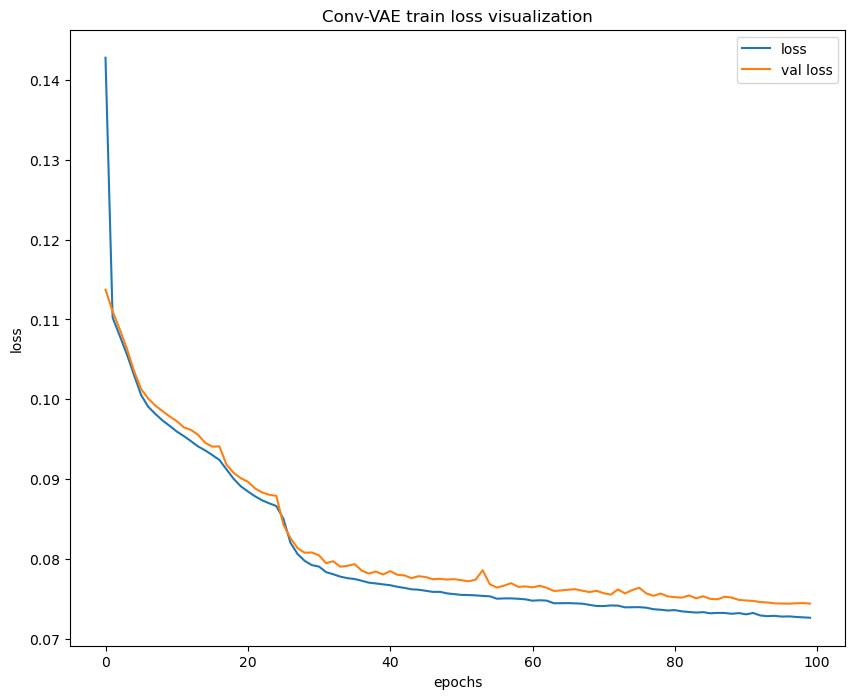

In [38]:
plt.figure(figsize = (10, 8))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'loss')
plt.plot([train_history[e]['test_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conv-VAE train loss visualization")
plt.legend(loc = 'best')
plt.show()

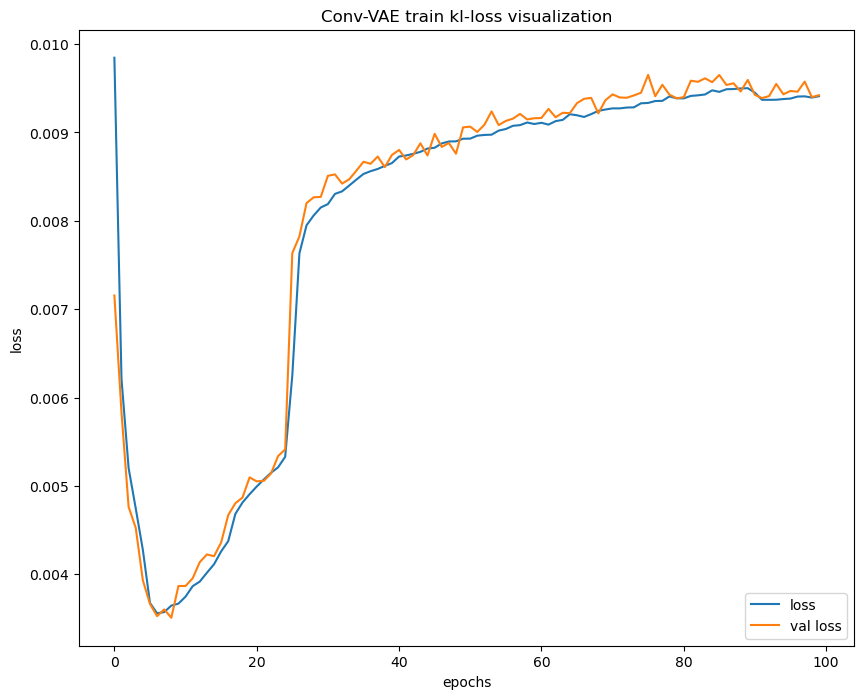

In [39]:
plt.figure(figsize = (10, 8))
plt.plot([train_history[e]['train_kl_loss'] for e in train_history.keys()], label = 'loss')
plt.plot([train_history[e]['test_kl_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conv-VAE train kl-loss visualization")
plt.legend(loc = 'best')
plt.show()

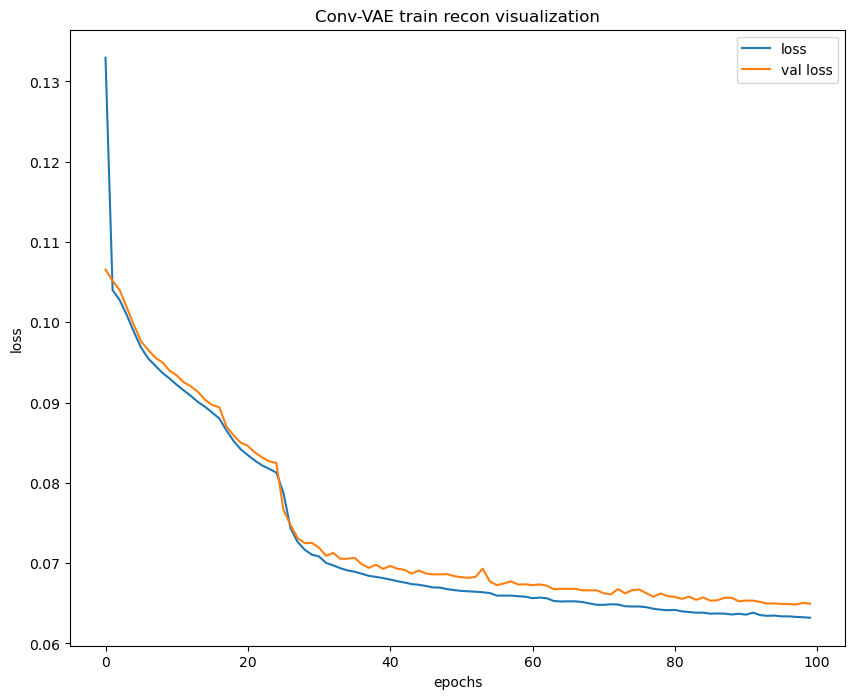

In [40]:
plt.figure(figsize = (10, 8))
plt.plot([train_history[e]['train_recon_loss'] for e in train_history.keys()], label = 'loss')
plt.plot([train_history[e]['test_recon_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conv-VAE train recon visualization")
plt.legend(loc = 'best')
plt.show()

In [41]:
del model

In [28]:
# Load trained weights from before-
trained_model = CVAE(latent_dim = 5, capacity = 16).to(device)
# trained_model.load_state_dict(torch.load('ConvVAE_MNIST_best_model.pth'))
trained_model.load_state_dict(torch.load('ConvVAE_MNIST_best_model.pth', map_location = torch.device('cpu')))

<All keys matched successfully>

In [29]:
def synthesize_images(model, batch_size = 128, latent_dim = 5):
    # Synthesize new MNIST images using trained 'model'.
    
    z = torch.randn(batch_size, latent_dim)
    x_synth = model.decoder(z).detach().cpu().numpy()
    return np.transpose(a = x_synth, axes = (0, 2, 3, 1))


In [38]:
x_synth = synthesize_images(
    model = trained_model, batch_size = batch_size,
    latent_dim = 5
)

In [39]:
x_synth.shape

(512, 28, 28, 1)

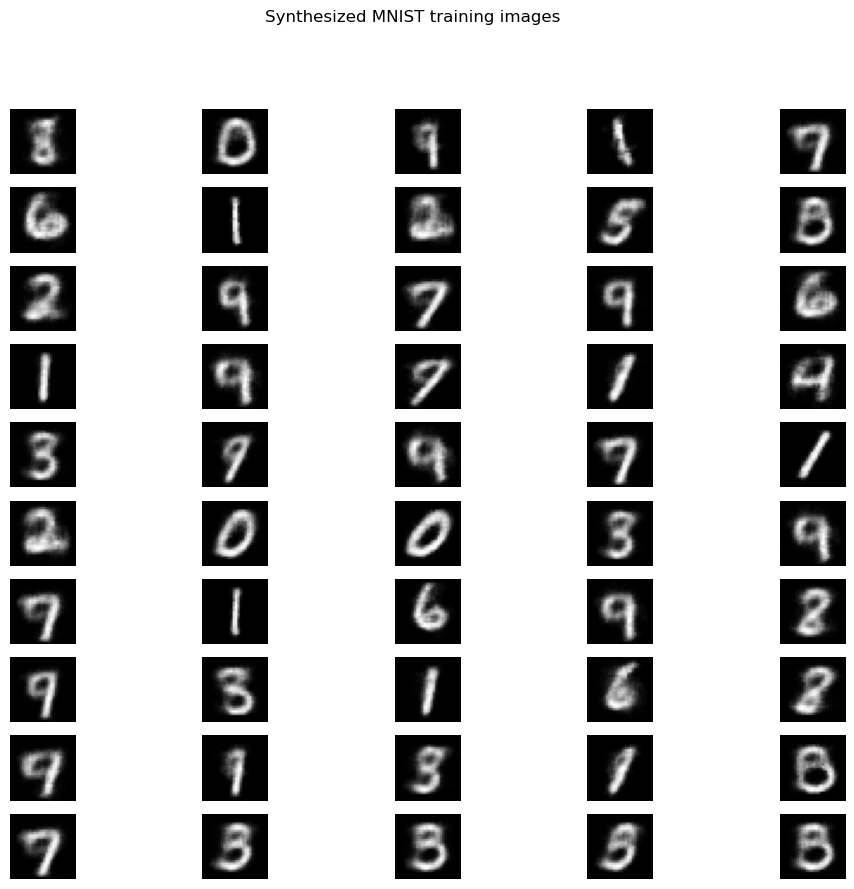

In [41]:
# Visualize synthesized images using trained VAE-
plt.figure(figsize = (12, 10))
for i in range(50):
    # 10 rows & 5 columns-
    plt.subplot(10, 5, i + 1)
    plt.imshow(x_synth[i], cmap = 'gray')
    plt.axis('off')
    
plt.suptitle("Synthesized MNIST training images")
plt.show()

#### Reconstruct images

Instead of sampling from a standard normal distribution, use ```mu``` and ```logvar``` of encoded images to reconstruct images (vs. synthesizing images).

In [31]:
x = next(iter(test_loader))

In [32]:
x_enc = trained_model.encoder(x)

mu = trained_model.mu(x_enc)
logvar = trained_model.log_var(x_enc)

# Compute standard deviation using 'log_var'-
std = torch.exp(0.5 * logvar)
z = mu + std

x_recon = trained_model.decoder(z).detach().cpu().numpy()
x_recon = np.transpose(a = x_recon, axes = (0, 2, 3, 1))

In [33]:
z.size()

torch.Size([512, 5])

In [34]:
z.min().item(), z.max().item()

(-2.587779998779297, 3.582871675491333)

In [35]:
x = x.detach().cpu().numpy()
x = np.transpose(a = x, axes = (0, 2, 3, 1))

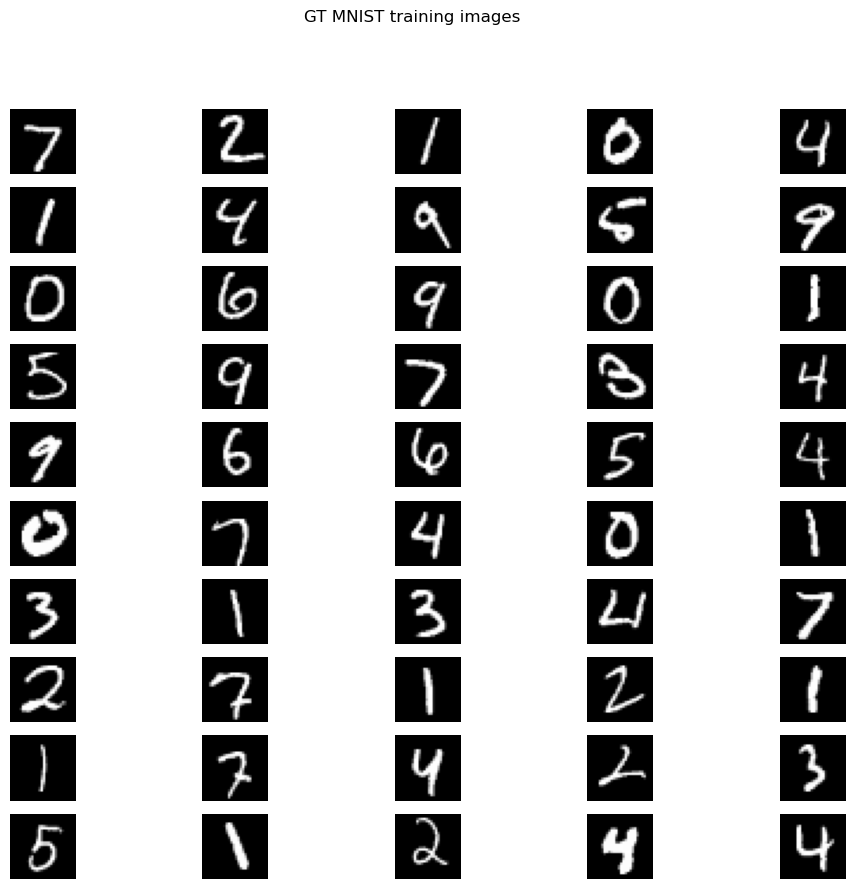

In [42]:
# Visualize synthesized images using trained VAE-
plt.figure(figsize = (12, 10))
for i in range(50):
    # 10 rows & 5 columns-
    plt.subplot(10, 5, i + 1)
    plt.imshow(x[i], cmap = 'gray')
    plt.axis('off')
    
plt.suptitle("GT MNIST training images")
plt.show()

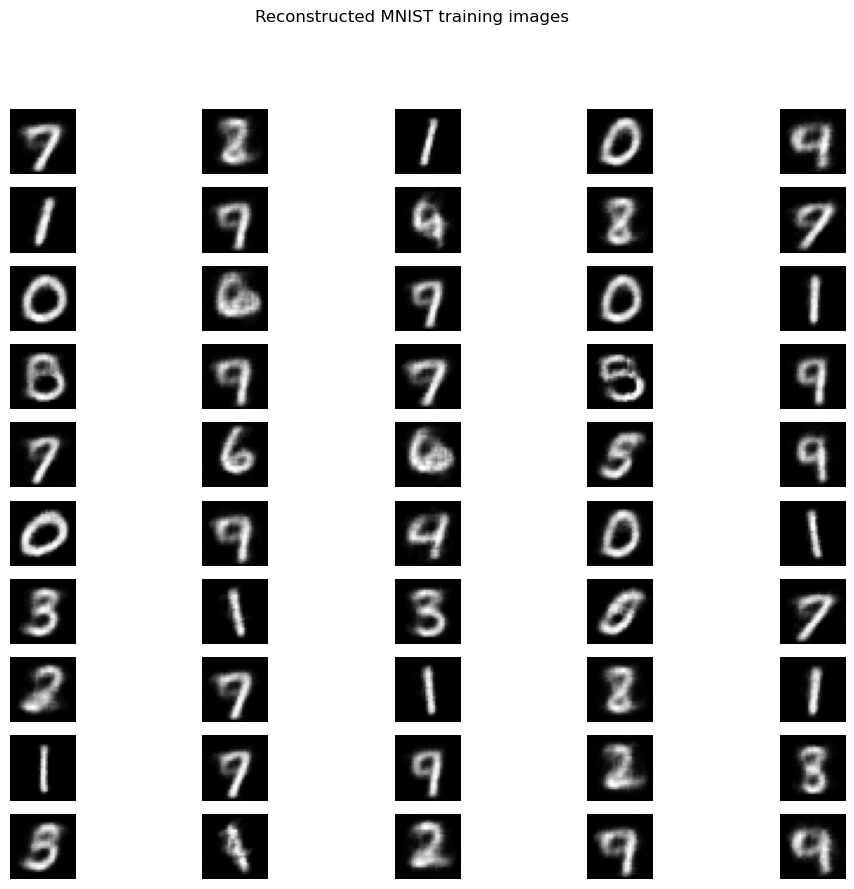

In [43]:
# Visualize synthesized images using trained VAE-
plt.figure(figsize = (12, 10))
for i in range(50):
    # 10 rows & 5 columns-
    plt.subplot(10, 5, i + 1)
    plt.imshow(x_recon[i], cmap = 'gray')
    plt.axis('off')
    
plt.suptitle("Reconstructed MNIST training images")
plt.show()